Quantum Convolutional Neural Network (QCNN) for 4×4 Images
We’re going to build a tiny quantum neural network that learns to tell apart two kinds of clothing using Fashion-MNIST images shrunk down to 4×4 pixels.
This will help us understand how quantum circuits can work a bit like CNNs.

Step 0: Install & Import libraries

Here we load all the tools we’ll need.
Think of it like grabbing your pencils and notebooks before you start a project.
We import:

PyTorch for normal machine learning

PennyLane for the quantum circuit

TorchVision for getting image data

Matplotlib for graphs

Some standard Python utilities for math, time, and files

In [1]:
# ===================== 0) SETUP: installs + imports ===========================
# this cell installs & loads everything for the QCNN notebook.
# it fixes BOTH issues we've seen:
#   1) autoray.NumpyMimic  -> by pinning autoray to 0.7.2 with PennyLane 0.39.0
#   2) jax.core.Primitive  -> by pinning jax/jaxlib to a matching pair

# --- install section (clean + pin) ---
# wipe conflicting versions first (safe if not installed)
!pip uninstall -y pennylane pennylane-lightning autoray jax jaxlib >/dev/null 2>&1

# install compatible, known-good versions
# notes:
# - jax==0.4.30 and jaxlib==0.4.30 are a matched set that works on Python 3.12 (CPU wheel on Colab)
# - autoray==0.7.2 exposes autoray.autoray.NumpyMimic which PennyLane 0.39 uses
# - numpy<2.0 keeps older deps happy
!pip install --no-cache-dir \
  "numpy<2.0" \
  "jax==0.4.30" \
  "jaxlib==0.4.30" \
  "autoray==0.7.2" \
  "pennylane==0.39.0" \
  "pennylane-lightning==0.39.0" \
  "torch" "torchvision" "matplotlib" "tqdm"

# --- imports section ---
# now import everything we'll use across the notebook
import os, math, random, time, json      # basic python tools
import numpy as np                       # numbers
import matplotlib.pyplot as plt          # plots
from tqdm import tqdm                    # progress bars

import torch                             # deep learning
import torch.nn as nn                    # neural net layers
import torch.optim as optim              # optimizers
from torch.utils.data import DataLoader, Subset, TensorDataset  # data helpers

import torchvision                       # datasets (Fashion-MNIST/MNIST)
import torchvision.transforms as T       # transforms (resize, etc.)

import jax, jaxlib                       # ensure jax/jaxlib are aligned
import autoray                           # array backend used by PennyLane
import pennylane as qml                  # quantum ML
from pennylane import numpy as pnp       # PL's numpy wrapper

# --- quick sanity checks so I know it's fixed right now ---
print("Imports successful!")
print("versions -> numpy:", np.__version__)
print("versions -> jax:", jax.__version__, "| jaxlib:", jaxlib.__version__)
print("versions -> autoray:", autoray.__version__, "| pennylane:", qml.__version__)
print("NumpyMimic present?:", hasattr(autoray.autoray, "NumpyMimic"))

# (Tip) Once this cell runs successfully, go to Runtime ▶ Restart runtime once,
# then run Step 0.1 (seed/device) and the rest of the notebook.



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 372.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 MB 420.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 422.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 422.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 419.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
optax 0.2.6 requires jax>=0.5.3, but you have jax 0.4.30 which is incompatible.
optax 0.2.6 requires jaxlib>=0.5.3, but you have jaxlib 0.4.30 which is incompatible.
flax 0.10.7 requires jax>=0.6.0, but you have jax 0.4.30 which is incompatible.
orbax-checkpoint 0.11.28 requires jax>=0.6.0, but you have jax 0.4.30 which is incompatible.
Imports successful!
versions -> numpy: 1.26.4
versions -> jax: 0.4.30 | jaxlib: 0.4.30
vers

Step 0.1: Set random seed and pick device

This makes sure we get the same results each time (so the training doesn’t act random).
We also check if we have a GPU — if yes, we’ll use it; otherwise CPU is fine.

In [2]:
# ===================== 0.1) REPRO + DEVICE ===================================
SEED = 42                                # fix randomness so results are repeatable
random.seed(SEED)                        # seed python rng
np.random.seed(SEED)                     # seed numpy rng
torch.manual_seed(SEED)                  # seed pytorch cpu
torch.cuda.manual_seed_all(SEED)         # seed pytorch gpu (if any)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if I have one
print("Device:", DEVICE)                 # just telling me what it picked


Device: cuda


Step 1: Experiment setup

This is where we write all the settings in one place — like how big the images are, how many qubits we’ll use, how long to train, and how fast to learn.
It’s basically our project’s “control panel.”

In [3]:
# ===================== 1) CONFIG =============================================
# everything I might tweak lives in this dict so I don’t hunt it down in code
CFG = {
    "dataset": "fashionmnist",           # switch to "mnist" if I want digits
    "classes": [0, 1],                   # binary task: label A vs label B (I picked 0 vs 1)
    "img_size": 4,                       # shrink images to 4x4 so I only need 16 qubits
    "encode": "angle",                   # map pixel -> RY(pi*x) rotation
    "n_qubits": 16,                      # 4x4 = 16 qubits
    "train_samples_per_class": 400,      # training size per class (small because QCNN is slow)
    "val_samples_per_class": 100,        # validation size per class
    "test_samples_per_class": 200,       # test size per class
    "batch_size": 32,                    # small-ish batch is fine
    "epochs_qcnn": 8,                    # QCNN training epochs (can increase later)
    "epochs_cnn": 8,                     # classical baseline epochs
    "q_depth": 2,                        # how many (conv + pool) stages in the QCNN
    "pooling": "discard",                # simple pooling: keep one qubit from each pair
    "shots": None,                       # None = exact expectation (faster here). set int for sampling noise
    "lr_qcnn": 1e-2,                     # QCNN learning rate
    "lr_cnn": 1e-3,                      # classical CNN learning rate
}
print(CFG)                               # quick sanity print


{'dataset': 'fashionmnist', 'classes': [0, 1], 'img_size': 4, 'encode': 'angle', 'n_qubits': 16, 'train_samples_per_class': 400, 'val_samples_per_class': 100, 'test_samples_per_class': 200, 'batch_size': 32, 'epochs_qcnn': 8, 'epochs_cnn': 8, 'q_depth': 2, 'pooling': 'discard', 'shots': None, 'lr_qcnn': 0.01, 'lr_cnn': 0.001}


Step 2: Dataset helper functions

These small functions help us:

Download Fashion-MNIST automatically

Keep only the two classes we care about (like T-shirt vs Trouser)

Turn the images into tensors that PyTorch understands

They just clean and prepare the data before training.

In [4]:
# ===================== 2) DATA HELPERS =======================================
def get_ds(name="fashionmnist", train=True, transform=None):
    root = "./data"                      # folder where torchvision will cache data
    name = name.lower()                  # normalize the string
    if name == "fashionmnist":
        return torchvision.datasets.FashionMNIST(root, train=train, download=True, transform=transform)
    if name == "mnist":
        return torchvision.datasets.MNIST(root, train=train, download=True, transform=transform)
    raise ValueError("Unknown dataset name")  # if I typo’d something

def make_binary_subset(ds, class_a, class_b, max_per_class=None):
    idxs = []                            # which indices to keep
    count = {class_a: 0, class_b: 0}     # how many I’ve kept per class
    for i, (_, y) in enumerate(ds):      # loop over all samples
        if y in (class_a, class_b):      # only care about my two labels
            if (max_per_class is None) or (count[y] < max_per_class):  # cap per class
                idxs.append(i)           # keep this index
                count[y] += 1            # update class counter
    return Subset(ds, idxs)              # return a filtered view of the dataset

def to_tensor_dataset(subset):
    xs, ys = [], []                      # I’ll build two lists and stack at the end
    for x, y in subset:                  # x is image tensor (C,H,W), y is label
        xs.append(x)                     # keep the image
        ys.append(0 if y == CFG["classes"][0] else 1)  # map labels to 0/1 specifically
    X = torch.stack(xs, dim=0)           # shape [N,1,H,W]
    y = torch.tensor(ys, dtype=torch.long)  # shape [N]
    return TensorDataset(X, y)           # standard PyTorch dataset from tensors


Step 2.1: Load and resize data

Here we actually download the data, resize each image to 4×4 pixels, and split it into training, validation, and test sets.
So we end up with three boxes of data: one to train, one to check during training, and one final test box for after.

In [5]:
# ===================== 2.1) LOAD + DOWNSAMPLE ================================
transform = T.Compose([
    T.ToTensor(),                        # turn PIL image into [0,1] tensor
    T.Resize((CFG["img_size"], CFG["img_size"]), antialias=True),  # downsample to 4x4 cleanly
])

train_raw = get_ds(CFG["dataset"], train=True, transform=transform)  # raw train set with transforms
test_raw  = get_ds(CFG["dataset"], train=False, transform=transform) # raw test set

train_bin = make_binary_subset(train_raw, CFG["classes"][0], CFG["classes"][1],
                               max_per_class=CFG["train_samples_per_class"])   # filter train to 2 classes
val_bin   = make_binary_subset(train_raw, CFG["classes"][0], CFG["classes"][1],
                               max_per_class=CFG["val_samples_per_class"])     # small val set from train
test_bin  = make_binary_subset(test_raw,  CFG["classes"][0], CFG["classes"][1],
                               max_per_class=CFG["test_samples_per_class"])    # test set filtered

train_ds = to_tensor_dataset(train_bin)  # convert to easy tensors
val_ds   = to_tensor_dataset(val_bin)
test_ds  = to_tensor_dataset(test_bin)

len(train_ds), len(val_ds), len(test_ds) # just seeing sizes, harmless to run


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.20MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.9MB/s]


(800, 200, 400)

Step 2.2: Make DataLoaders

Now we organize our data into batches so the model gets small chunks at a time instead of the whole dataset.
It’s like feeding the network bite-sized pieces to learn faster.

In [6]:
# ===================== 2.2) DATALOADERS ======================================
train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,  drop_last=False)  # shuffle when training
val_loader   = DataLoader(val_ds,   batch_size=CFG["batch_size"], shuffle=False, drop_last=False)  # no need to shuffle val
test_loader  = DataLoader(test_ds,  batch_size=CFG["batch_size"], shuffle=False, drop_last=False)  # or test


Step 2.3: Visualize samples

Let’s peek at a few examples to make sure they look right after being shrunk to 4×4 pixels.
This helps confirm that everything downloaded and transformed correctly.

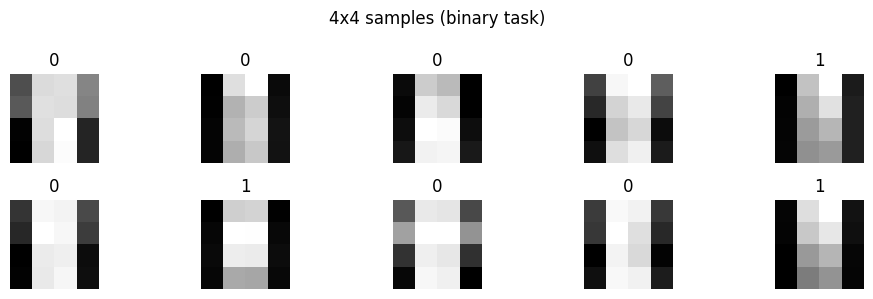

In [7]:
# ===================== 2.3) QUICK VISUAL CHECK ===============================
def show_grid(ds, n=10):
    plt.figure(figsize=(10,3))           # wide row
    for i in range(n):                   # show n samples
        x, y = ds[i]                     # grab image + label
        plt.subplot(2, n//2, i+1)        # 2 rows layout
        plt.imshow(x.squeeze(0), cmap="gray")  # remove channel dim, show gray
        plt.title(int(y))                # title with mapped label (0 or 1)
        plt.axis("off")                  # cleaner look
    plt.suptitle("4x4 samples (binary task)")  # header
    plt.tight_layout()                   # compact layout
show_grid(train_ds, n=10)                # sanity: does this look okay?


tep 3: Quantum circuit building blocks

Here we define the basic “quantum layers.”

Encoding: turns pixel values into qubit rotations.

Conv block: does rotations + CNOT entangling (like mixing info between pixels).

Pooling block: combines pairs of qubits and throws one away, shrinking the data (just like pooling in CNNs).

These are the main building blocks of the QCNN.

In [8]:
# ===================== 3) QCNN: CIRCUIT PIECES ===============================
def angle_encode(img_flat):
    # img_flat is length == number of qubits (e.g., 16 floats in [0,1])
    for i, val in enumerate(img_flat):   # loop each pixel value
        qml.RY(np.pi * val, wires=i)     # rotate qubit i by pi*pixel (this is how info enters the circuit)

def conv_block(params, wires):
    # one "quantum conv layer": local rotations + a ring of entanglers
    # params shape is [len(wires), 2] -> each wire gets (theta_y, theta_z)
    n = len(wires)                        # how many qubits in this layer
    for wi, (th_y, th_z) in zip(wires, params):  # go wire-by-wire
        qml.RY(th_y, wires=wi)            # learnable rotation around Y
        qml.RZ(th_z, wires=wi)            # learnable rotation around Z
    for i in range(n):                     # entangle neighbors in a ring
        qml.CNOT(wires=[wires[i], wires[(i+1) % n]])  # simple CNOT ring

def two_qubit_block(theta, w0, w1):
    # tiny two-qubit unitary I’ll reuse inside pooling
    # theta has 4 params: [ry0, rz0, ry1, rz1]
    qml.RY(theta[0], wires=w0)            # rotate first qubit
    qml.RZ(theta[1], wires=w0)
    qml.RY(theta[2], wires=w1)            # rotate second qubit
    qml.RZ(theta[3], wires=w1)
    qml.CNOT(wires=[w0, w1])              # entangle them
    # could add more gates here if I want more expressivity

def pooling_layer(params, wires, mode="discard"):
    # pool by pairs: (w0,w1) -> do a 2-qubit unitary then "keep" just w0
    # params shape is [len(wires)//2, 4]
    assert len(wires) % 2 == 0            # must be even number of wires to pair up
    new_wires = []                         # wires I keep after pooling
    pair_params = params.reshape(-1, 4)    # make it easy to index per pair
    for k in range(0, len(wires), 2):      # step in pairs
        w0, w1 = wires[k], wires[k+1]      # pair
        two_qubit_block(pair_params[k//2], w0, w1)  # apply small unitary
        new_wires.append(w0)               # keep w0, drop w1 (that’s the “discard” pool)
    return new_wires                       # fewer wires now (half as many)


Step 3.1: The QCNN model

Now we wrap everything into one PyTorch model that talks to PennyLane.
This creates a QNode (quantum node) that:

Takes in an image

Encodes it on qubits

Runs multiple conv + pooling layers

Measures the final qubits

Sends those results into a tiny classical linear layer to make the final prediction.

So this is our full quantum-classical hybrid model.

In [9]:
# ===================== 3.1) QCNN MODULE (Torch wrapper around a QNode) =======
class QCNN(nn.Module):
    def __init__(self, n_qubits=16, q_depth=2, pooling="discard", shots=None):
        super().__init__()                 # boilerplate module init
        self.n_qubits = n_qubits           # total qubits at start
        self.q_depth  = q_depth            # how many conv+pool stages
        self.pooling  = pooling            # pooling mode string

        # pick device: analytic (no noise) or shot-based (samples -> noisy, slower)
        if shots is None:
            self.dev = qml.device("default.qubit", wires=n_qubits)     # exact expecs
        else:
            self.dev = qml.device("default.qubit", wires=n_qubits, shots=shots)  # sampling

        # I build a "wire schedule" so I know how many params per stage
        wire_schedule = []                 # keeps track of wires before/after each pool
        w = list(range(n_qubits))          # start with all wires [0..n-1]
        for _ in range(q_depth):           # repeat conv+pool q_depth times
            wire_schedule.append(list(w))  # conv runs on these wires
            w = w[::2]                     # pooling keeps every other
            wire_schedule.append(list(w))  # after pooling, these wires remain
        self.wire_schedule = wire_schedule # store for later

        # figure out how many parameters I need for conv + pool layers
        conv_sizes = [ (len(ws), 2) for i, ws in enumerate(self.wire_schedule) if i % 2 == 0 ]  # each wire gets 2 angles
        pool_sizes = [ (len(self.wire_schedule[i-1])//2, 4) for i in range(1, len(self.wire_schedule), 2) ]  # each pair gets 4

        self.conv_shapes = [ (m, n) for (m,n) in conv_sizes ]  # list of shapes like (num_wires, 2)
        self.pool_shapes = [ (m, n) for (m,n) in pool_sizes ]  # list of shapes like (num_pairs, 4)
        self.total_conv  = sum(m*n for (m,n) in self.conv_shapes)  # total conv params flattened
        self.total_pool  = sum(m*n for (m,n) in self.pool_shapes)  # total pool params flattened

        # one flat parameter vector to make life easy; I’ll slice it inside the QNode
        self.theta = nn.Parameter(torch.zeros(self.total_conv + self.total_pool, dtype=torch.float32))

        # after final pooling, however many wires are left = feature size for classifier
        self.final_wires = self.wire_schedule[-1]              # wires we end with
        self.classifier = nn.Linear(len(self.final_wires), 2)  # small linear head to 2 logits

        # define the quantum function (QNode) that uses my parameters + input
        @qml.qnode(self.dev, interface="torch", diff_method="best")
        def circuit(x, flat_theta):         # x is input vector length == n_qubits
            # split flat theta back into conv/pool chunks
            t = flat_theta                   # alias
            conv_list, pool_list = [], []    # containers
            offset = 0                       # where I’m slicing from

            # unpack conv params in order
            for (m,n) in self.conv_shapes:   # each conv layer: (num_wires, 2)
                size = m*n
                conv_list.append( t[offset:offset+size].reshape(m,n) )  # reshape chunk
                offset += size

            # unpack pool params in order
            for (m,n) in self.pool_shapes:   # each pool layer: (num_pairs, 4)
                size = m*n
                pool_list.append( t[offset:offset+size].reshape(m,n) )  # reshape chunk
                offset += size

            wires = list(range(self.n_qubits))  # start with all wires

            angle_encode(x)                  # push image into the circuit as rotations

            pool_idx = 0                     # which pool param set I am on
            for conv_params in conv_list:    # loop conv layers
                conv_block(conv_params, wires)        # do local rot + entangle ring
                wires = pooling_layer(pool_list[pool_idx], wires, mode=self.pooling)  # reduce wires
                pool_idx += 1

            # at the end, measure Z expectation on each remaining wire
            return [qml.expval(qml.PauliZ(w)) for w in wires]

        self.qnode = circuit                # store QNode so I can call it in forward()

    def forward(self, x):
        # x has shape [B, 1, H, W]; I need a flat vector per example
        B = x.shape[0]                      # batch size
        x_flat = x.view(B, -1)              # flatten each image to length n_qubits
        outs = []                           # I’ll collect circuit outputs here
        for i in range(B):                  # quantum node runs per-example
            out_i = self.qnode(x_flat[i], self.theta)       # run circuit with my params
            outs.append(torch.stack(out_i))                 # stack list of expvals
        feats = torch.stack(outs, dim=0)    # shape [B, num_final_wires]
        logits = self.classifier(feats)     # map features -> 2 logits (binary)
        return logits                       # standard PyTorch forward()


Step 4: Classical CNN baseline

To see if our QCNN is any good, we’ll make a tiny regular CNN that has roughly the same number of parameters.
This lets us compare “quantum vs normal.”

In [10]:
# ===================== 4) CLASSICAL BASELINE (tiny CNN) =======================
class TinyCNN(nn.Module):
    def __init__(self, in_ch=1, img_size=4, feat=8):
        super().__init__()                  # basic nn.Module init
        # two small convs to squish 4x4 -> 2x2 feature maps
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, feat, kernel_size=2, stride=1, padding=0),  # 4x4 -> 3x3
            nn.ReLU(),                                                   # nonlinearity
            nn.Conv2d(feat, feat, kernel_size=2, stride=1, padding=0),   # 3x3 -> 2x2
            nn.ReLU(),
        )
        flat = feat * 2 * 2              # flatten size after convs
        self.head = nn.Linear(flat, 2)   # final linear to 2 classes

    def forward(self, x):
        z = self.conv(x)                  # conv features
        z = z.view(z.size(0), -1)         # flatten
        return self.head(z)               # logits


Step 5: Training and testing helpers

We define functions to handle training and validation loops.
These track loss and accuracy, and work for both the QCNN and CNN models.
They basically do: forward → calculate loss → update weights (for training) → return results.

In [11]:
# ===================== 5) TRAIN/EVAL HELPERS =================================
def accuracy_from_logits(logits, ytrue):
    preds = logits.argmax(dim=1)          # take most likely class
    return (preds == ytrue).float().mean().item()  # average correctness across batch

def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None      # if optimizer exists, this is training
    model.train(is_train)                 # set mode (important for e.g., dropout/bn)
    total_loss, total_acc, total_n = 0.0, 0.0, 0  # running sums
    ce = nn.CrossEntropyLoss()            # standard classification loss
    for xb, yb in loader:                 # loop batches
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)      # move to GPU/CPU as chosen
        logits = model(xb)                         # forward pass
        loss = ce(logits, yb)                      # compute loss
        if is_train:                               # backprop only in training
            optimizer.zero_grad()                  # clear old grads
            loss.backward()                        # compute new grads
            optimizer.step()                       # apply update
        acc = accuracy_from_logits(logits, yb)     # compute batch accuracy
        bs = xb.size(0)                            # batch size
        total_loss += loss.item() * bs             # sum weighted by batch
        total_acc  += acc * bs
        total_n    += bs
    return total_loss/total_n, total_acc/total_n   # average over dataset


Step 6: Train the QCNN

Here we actually train our quantum model!
It goes through the training data several times (epochs), adjusting the quantum angles until it gets good at classifying.
After each epoch we also check accuracy on the validation set to make sure it’s learning.

this takes about 23 minites

In [12]:
# ===================== 6) TRAIN QCNN (with dtype fix) ========================
qcnn = QCNN(
    n_qubits=CFG["n_qubits"],    # 16 for 4x4
    q_depth=CFG["q_depth"],      # how many conv+pool stacks
    pooling=CFG["pooling"],      # "discard" pooling
    shots=CFG["shots"]           # None = analytic expectations
).to(DEVICE)                     # put model on GPU/CPU

# ---- dtype patch: make QCNN outputs float32 before the classifier ----
def _qcnn_forward_fp32(self, x):
    B = x.shape[0]                          # batch size
    x_flat = x.view(B, -1)                  # flatten images to length n_qubits
    outs = []
    for i in range(B):                      # run the quantum node per example
        out_i = self.qnode(x_flat[i], self.theta)       # expvals (float64)
        outs.append(torch.stack(out_i))                 # collect as tensor
    feats = torch.stack(outs, dim=0)                    # [B, num_final_wires]
    # cast to same dtype/device as the linear head (fixes Double vs Float error)
    feats = feats.to(dtype=self.classifier.weight.dtype, device=x.device)
    logits = self.classifier(feats)                     # 2-class logits
    return logits

QCNN.forward = _qcnn_forward_fp32   # monkey-patch the class so this instance uses it

opt_q = optim.Adam(qcnn.parameters(), lr=CFG["lr_qcnn"])  # Adam optimizer

history_q = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}  # logs

for epoch in range(1, CFG["epochs_qcnn"]+1):     # training loop
    t0 = time.time()                              # just to time the epoch
    tr_loss, tr_acc = run_epoch(qcnn, train_loader, optimizer=opt_q)   # train pass
    va_loss, va_acc = run_epoch(qcnn, val_loader, optimizer=None)      # val pass
    history_q["train_loss"].append(tr_loss)
    history_q["train_acc"].append(tr_acc)
    history_q["val_loss"].append(va_loss)
    history_q["val_acc"].append(va_acc)
    dt = time.time() - t0
    print(f"[QCNN] Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f} | {dt:.1f}s")



[QCNN] Epoch 01 | train 0.6977/0.500 | val 0.5914/0.500 | 171.6s
[QCNN] Epoch 02 | train 0.4740/0.855 | val 0.3819/0.875 | 170.4s
[QCNN] Epoch 03 | train 0.3379/0.879 | val 0.2960/0.885 | 169.5s
[QCNN] Epoch 04 | train 0.2740/0.902 | val 0.2497/0.910 | 169.7s
[QCNN] Epoch 05 | train 0.2393/0.929 | val 0.2292/0.915 | 169.0s
[QCNN] Epoch 06 | train 0.2214/0.927 | val 0.2136/0.935 | 169.0s
[QCNN] Epoch 07 | train 0.2116/0.929 | val 0.2047/0.935 | 169.2s
[QCNN] Epoch 08 | train 0.2055/0.926 | val 0.1986/0.935 | 169.4s


Step 7: Train the Classical CNN

Now we train the regular CNN on the same data for the same number of epochs.
We’ll later compare the two models’ accuracy and loss to see which performs better.

this should be immediate

In [13]:
# ===================== 7) TRAIN CLASSICAL CNN ================================
cnn = TinyCNN(in_ch=1, img_size=CFG["img_size"], feat=8).to(DEVICE)  # tiny model
opt_c = optim.Adam(cnn.parameters(), lr=CFG["lr_cnn"])               # separate LR

history_c = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}  # logbook

for epoch in range(1, CFG["epochs_cnn"]+1):     # loop epochs
    t0 = time.time()                             # timestamp
    tr_loss, tr_acc = run_epoch(cnn, train_loader, optimizer=opt_c)  # train
    va_loss, va_acc = run_epoch(cnn, val_loader, optimizer=None)     # val
    history_c["train_loss"].append(tr_loss)      # log
    history_c["train_acc"].append(tr_acc)
    history_c["val_loss"].append(va_loss)
    history_c["val_acc"].append(va_acc)
    dt = time.time() - t0                        # time
    print(f"[CNN ] Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f} | {dt:.1f}s")


[CNN ] Epoch 01 | train 0.6899/0.500 | val 0.6862/0.500 | 0.9s
[CNN ] Epoch 02 | train 0.6835/0.500 | val 0.6780/0.500 | 0.1s
[CNN ] Epoch 03 | train 0.6728/0.500 | val 0.6638/0.500 | 0.1s
[CNN ] Epoch 04 | train 0.6574/0.601 | val 0.6448/0.595 | 0.1s
[CNN ] Epoch 05 | train 0.6358/0.689 | val 0.6197/0.825 | 0.1s
[CNN ] Epoch 06 | train 0.6105/0.780 | val 0.5889/0.855 | 0.1s
[CNN ] Epoch 07 | train 0.5845/0.786 | val 0.5618/0.830 | 0.1s
[CNN ] Epoch 08 | train 0.5563/0.800 | val 0.5307/0.845 | 0.1s


Step 8: Test both models

Time to test!
We run both trained models on the test data (new images they haven’t seen) and check their final accuracy.
This tells us which one generalizes better.

this takes about 45 seconds

In [14]:
# ===================== 8) TEST BOTH MODELS ===================================
q_test_loss, q_test_acc = run_epoch(qcnn, test_loader, optimizer=None)  # QCNN on test
c_test_loss, c_test_acc = run_epoch(cnn,  test_loader, optimizer=None)  # CNN on test

print(f"QCNN  test: loss={q_test_loss:.4f}, acc={q_test_acc:.3f}")       # final QCNN numbers
print(f"Class  test: loss={c_test_loss:.4f}, acc={c_test_acc:.3f}")      # final CNN numbers


QCNN  test: loss=0.1935, acc=0.938
Class  test: loss=0.5447, acc=0.807


Step 9: Plot training results

We make line graphs showing accuracy and loss over time for both models.
This helps visualize if one learns faster or more steadily than the other.

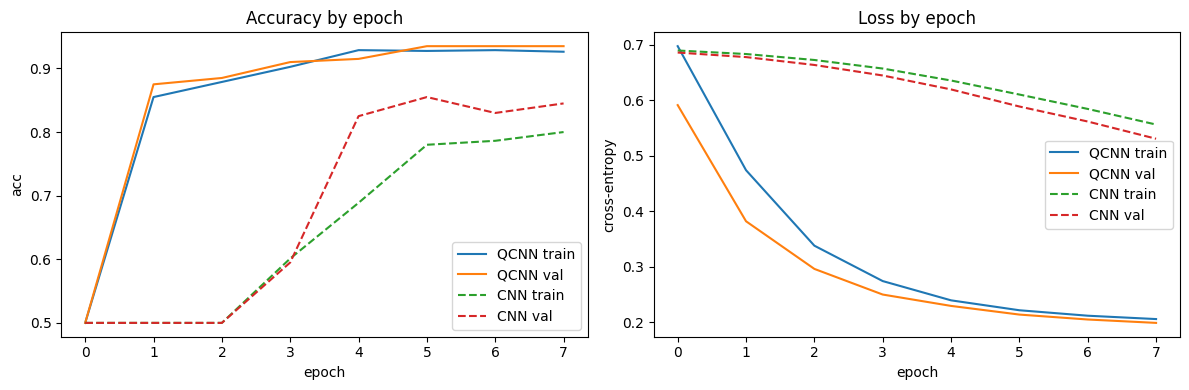

In [15]:
# ===================== 9) PLOTS ==============================================
plt.figure(figsize=(12,4))                            # make a wide figure
plt.subplot(1,2,1)                                    # left plot
plt.plot(history_q["train_acc"], label="QCNN train")  # QCNN train acc
plt.plot(history_q["val_acc"],   label="QCNN val")    # QCNN val acc
plt.plot(history_c["train_acc"], label="CNN train", linestyle="--")  # CNN train
plt.plot(history_c["val_acc"],   label="CNN val", linestyle="--")    # CNN val
plt.title("Accuracy by epoch")                        # label
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()

plt.subplot(1,2,2)                                    # right plot
plt.plot(history_q["train_loss"], label="QCNN train") # QCNN train loss
plt.plot(history_q["val_loss"],   label="QCNN val")   # QCNN val loss
plt.plot(history_c["train_loss"], label="CNN train", linestyle="--")  # CNN train loss
plt.plot(history_c["val_loss"],   label="CNN val", linestyle="--")    # CNN val loss
plt.title("Loss by epoch")
plt.xlabel("epoch")
plt.ylabel("cross-entropy")
plt.legend()

plt.tight_layout()                                    # tidy layout
plt.show()                                            # display


Step 9.1: Save summary figure

We make a simple bar chart comparing final test accuracies for the QCNN and CNN.
It’s an easy way to show results at a glance and save the image to a file.

Saved: qcnn_vs_cnn_accuracy.png


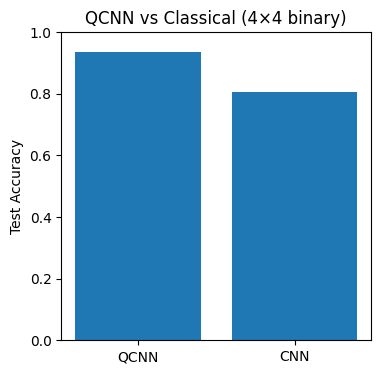

In [16]:
# ===================== 9.1) SAVE A SIMPLE SUMMARY FIG ========================
fig = plt.figure(figsize=(4,4))                       # small bar chart
plt.bar(["QCNN","CNN"], [q_test_acc, c_test_acc])     # compare test acc
plt.ylabel("Test Accuracy")
plt.title("QCNN vs Classical (4×4 binary)")
plt.ylim(0,1)                                         # accuracy is between 0 and 1
out_path = "qcnn_vs_cnn_accuracy.png"                 # filename
plt.savefig(out_path, dpi=300, bbox_inches="tight")   # write to disk
print("Saved:", out_path)                             # confirmation


Step 10a: Parameter count

We print how many trainable parameters each model has.
This shows how “big” or complex the QCNN is compared to the classical CNN.

In [17]:
# ===================== 10) NICE-TO-HAVES (OPTIONAL) ==========================
# 10a) parameter counts so I can compare sizes
def count_params(model):
    return sum(p.numel() for p in model.parameters())  # just count all numbers

print("QCNN params:", count_params(qcnn))              # how many learnable params in QCNN (quantum + head)
print("CNN  params:", count_params(cnn))               # how many in tiny CNN


QCNN params: 106
CNN  params: 370


Step 10b: Visualize the QCNN circuit

Here we draw the actual quantum circuit used in the QCNN.
This lets us see the sequence of rotations, CNOTs, and pooling steps inside our model.

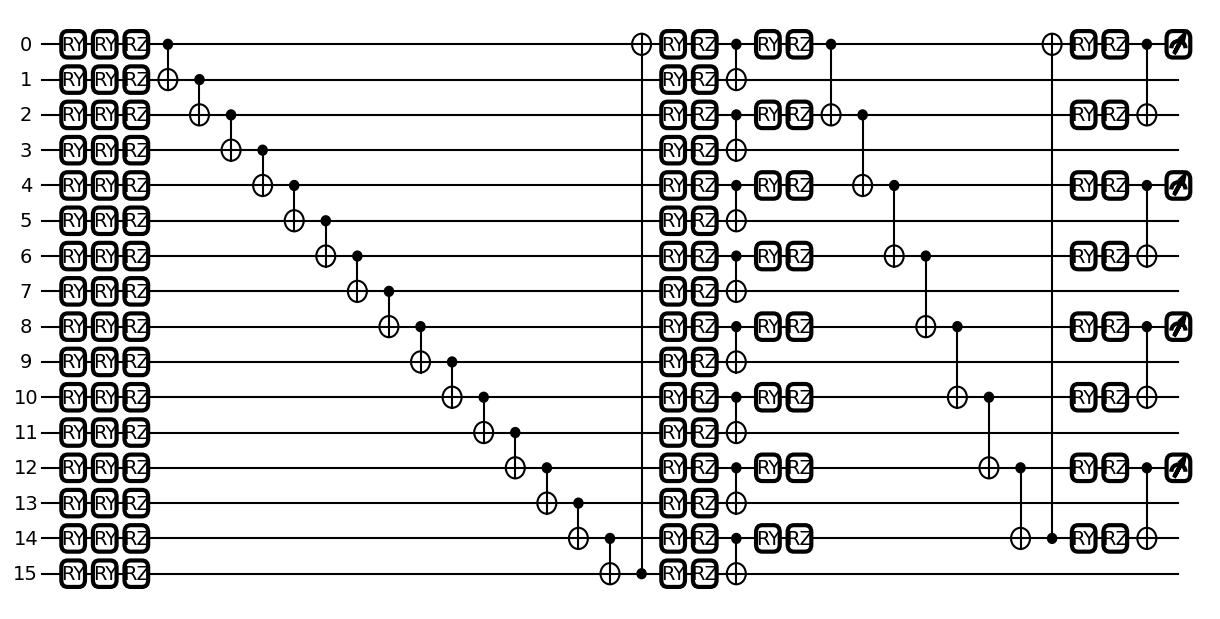

In [18]:
# 10b) draw qcNN circuit for one sample (text diagram; can be long)
example_x, _ = train_ds[0]                             # take one training image
example_x = example_x.view(-1)                         # flatten to length 16

@qml.qnode(qcnn.dev)                                   # use same device as model
def draw_circuit(x, flat_theta):
    angle_encode(x)                                    # put data in
    # manually rebuild params, like forward() does
    t = flat_theta
    conv_shapes = qcnn.conv_shapes
    pool_shapes = qcnn.pool_shapes
    convs, pools = [], []
    offset = 0
    for (m,n) in conv_shapes:
        convs.append(t[offset:offset+m*n].reshape(m,n)); offset += m*n
    for (m,n) in pool_shapes:
        pools.append(t[offset:offset+m*n].reshape(m,n)); offset += m*n
    wires = list(range(qcnn.n_qubits))
    pool_idx = 0
    for conv_params in convs:
        conv_block(conv_params, wires)
        wires = pooling_layer(pools[pool_idx], wires, mode=qcnn.pooling)
        pool_idx += 1
    return [qml.expval(qml.PauliZ(w)) for w in wires]  # measure final wires

fig, ax = qml.draw_mpl(draw_circuit)(example_x.numpy(), qcnn.theta.detach().cpu().numpy())  # draw as matplotlib
fig.set_size_inches(12,6)                              # make it readable
plt.show()                                             # display circuit picture


Step 10c: Save models and settings

Finally, we save the trained weights and configuration to files.
That way, we can reload or share the models later without retraining.

In [19]:
# 10c) save weights + config so I can reload later
os.makedirs("artifacts", exist_ok=True)                # make folder if missing
torch.save(qcnn.state_dict(), "artifacts/qcnn.pt")     # save QCNN weights
torch.save(cnn.state_dict(),  "artifacts/cnn.pt")      # save CNN weights
with open("artifacts/config.json","w") as f:           # save my CFG too
    json.dump(CFG, f, indent=2)
print("Saved to ./artifacts")                          # done


Saved to ./artifacts


quick notes (why things are the way they are)

why 4×4 images? 4×4 → 16 pixels → 16 qubits. that’s already non-trivial for a laptop. bigger images = more qubits = slower/harder.

angle encoding: easiest way to feed numbers into a circuit: RY(pi*x) per qubit. could try fancier maps later.

conv + pool idea: conv = local rotations + entanglement (like mixing info within a patch). pool = throw away half the wires to shrink “spatial” size.

discard pooling: I keep every other qubit after a small 2-qubit block. dead simple and differentiable.

analytic vs shots: shots=None gives exact expectations (fast + stable). if you want hardware-ish noise, set shots=1000 (slower, noisy grads).

classical baseline: tiny CNN with similar scale so comparisons feel fair (not perfect, but reasonable for a toy).

In [20]:
# ===================== 7) EVALUATE OVERFITTING =============================
import torch

# Put model in evaluation mode
qcnn.eval()

# Disable gradient tracking for faster inference
with torch.no_grad():
    train_loss, train_acc = run_epoch(qcnn, train_loader, optimizer=None)
    val_loss, val_acc = run_epoch(qcnn, val_loader, optimizer=None)
    test_loss, test_acc = run_epoch(qcnn, test_loader, optimizer=None)

print("\n================== QCNN EVALUATION RESULTS ==================")
print(f"Training Accuracy:   {train_acc*100:.2f}%")
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Testing Accuracy:    {test_acc*100:.2f}%")
print("==============================================================")

# Simple overfitting check
if (train_acc - val_acc) > 0.1:
    print("\nPotential Overfitting Detected: "
          "Model is performing significantly better on training data.")
else:
    print("\n Model appears to generalize well (no major overfitting).")



================== QCNN EVALUATION RESULTS ==================
Training Accuracy:   93.38%
Validation Accuracy: 93.50%
Testing Accuracy:    93.75%

 Model appears to generalize well (no major overfitting).


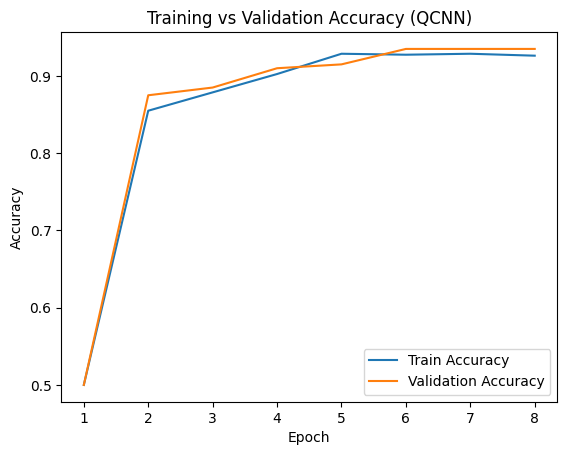

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_q["train_acc"]) + 1)

plt.plot(epochs, history_q["train_acc"], label='Train Accuracy')
plt.plot(epochs, history_q["val_acc"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (QCNN)')
plt.legend()
plt.show()


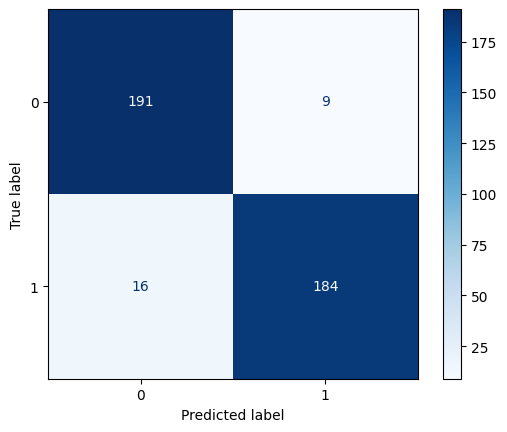

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        preds = qcnn(x.to(DEVICE))
        all_preds.extend(preds.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.show()


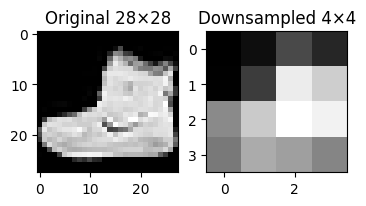

In [27]:
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST

# Load dataset (raw images)
ds = FashionMNIST(root="./data", train=True, download=True)

# Downsampling transform (for the 4×4 grid)
down = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((4, 4)),
    transforms.ToTensor()
])

# Get one example
img, label = ds[0]

# Convert to tensor for visualization (since original is PIL)
img_tensor = transforms.ToTensor()(img)
down_tensor = down(img)

# Plot both versions
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title("Original 28×28")

plt.subplot(1,2,2)
plt.imshow(down_tensor.squeeze(), cmap='gray')
plt.title("Downsampled 4×4")

plt.show()



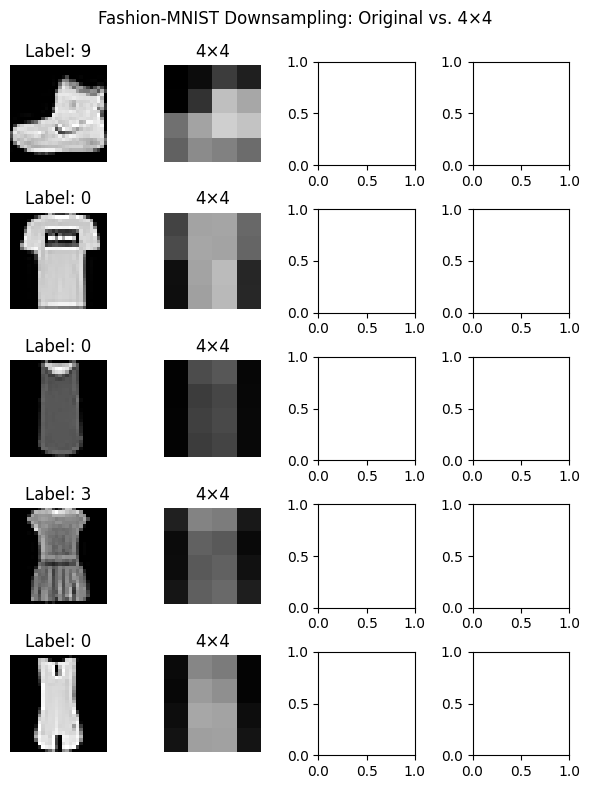

In [28]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch

# Load dataset
ds = datasets.FashionMNIST(root="./data", train=True, download=True)

# Downsampling transform (4×4)
down = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((4, 4)),
    transforms.ToTensor()
])

# Plot several examples
fig, axes = plt.subplots(5, 4, figsize=(6, 8))
for i in range(5):
    img, label = ds[i]
    img_tensor = transforms.ToTensor()(img)
    down_tensor = down(img)
    # Original
    axes[i, 0].imshow(img_tensor.squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Label: {label}")
    axes[i, 0].axis('off')
    # 4×4 version
    axes[i, 1].imshow(down_tensor.squeeze(), cmap='gray', vmin=0, vmax=1)
    axes[i, 1].set_title("4×4")
    axes[i, 1].axis('off')

# Make layout clean
plt.suptitle("Fashion-MNIST Downsampling: Original vs. 4×4")
plt.tight_layout()
plt.show()


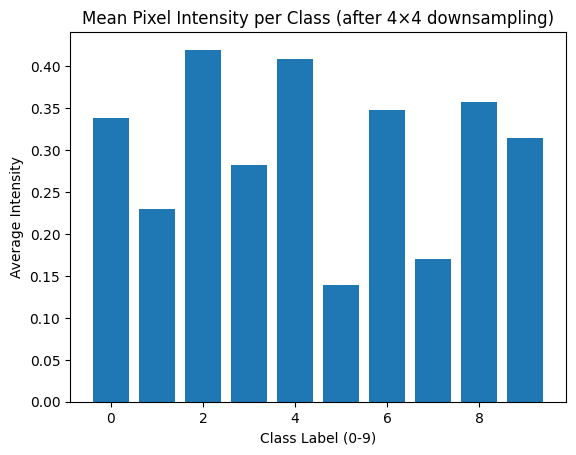

In [29]:
import numpy as np

down = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((4, 4)),
    transforms.ToTensor()
])

# Compute average intensity per class
class_means = [[] for _ in range(10)]
for i in range(1000):  # sample subset for speed
    img, label = ds[i]
    arr = down(img).numpy().flatten()
    class_means[label].append(arr.mean())

# Calculate overall averages
means = [np.mean(m) for m in class_means]

plt.bar(range(10), means)
plt.title("Mean Pixel Intensity per Class (after 4×4 downsampling)")
plt.xlabel("Class Label (0-9)")
plt.ylabel("Average Intensity")
plt.show()


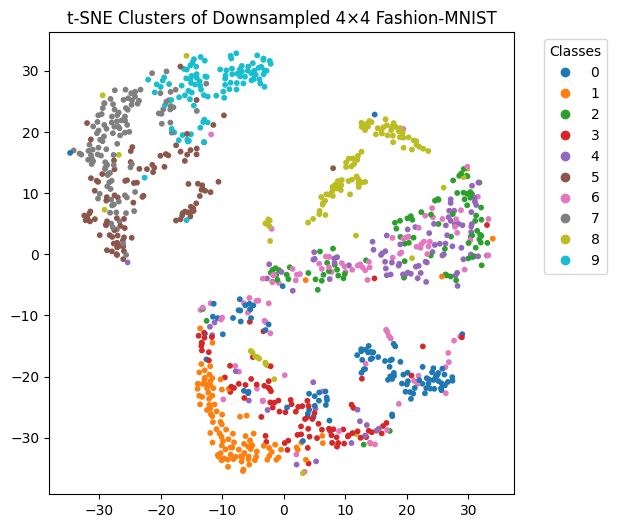

In [30]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X = []
y = []

for i in range(1000):
    img, label = ds[i]
    arr = down(img).numpy().flatten()
    X.append(arr)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Standardize before t-SNE
X_scaled = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6,6))
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05,1))
plt.title("t-SNE Clusters of Downsampled 4×4 Fashion-MNIST")
plt.show()
